# Business Understanding
Grocery stores handle large quantities of fruits every day. It's important that they are able to catagorize them and determine whether they are fresh or rotten. That's where this dataset come in. The dataset we chose is a collection of images of strawberries, peaches, and pomegranates. Each image is a .jpg with a white background and an image size of 300*300.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Load image data from directory
fruits = ['peach', 'pomegranate', 'strawberry']

# Set the image size
h, w = 50, 50

data_set = [] # Image data
dataset_target = [] # Target information, [fresh/rotten, fruit type]

for fruit in fruits:
    fruit_type = ['fresh', 'rotten']
    for ft in fruit_type:
        # Open the directory
        path = f'./data/{ft}/{fruit}'

        # Load the image data
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))

            # Set color to RGB
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            # Resize the image
            img_array = cv2.resize(img_array, (h, w))

            # Flatten the image
            img_array = img_array.flatten()
            data_set.append(img_array)

            # Add the target information
            dataset_target.append(list([ft, fruit]))


data_set[0].shape

(7500,)

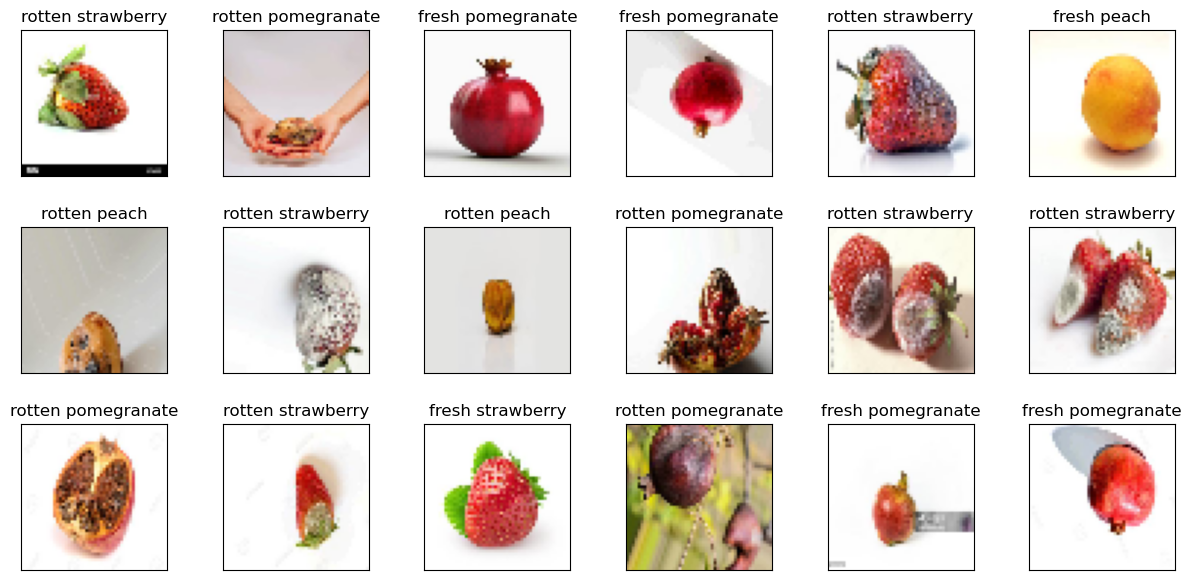

In [14]:
import random

def plot_rand_gallery(images, titles, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plot_index=random.sample(range(0,len(data_set)),n_row * n_col)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[plot_index[i]].reshape((h, w, 3)))
        title = titles[plot_index[i]][0] + " " + titles[plot_index[i]][1]
        plt.title(title, size=12)
        plt.xticks(())
        plt.yticks(())

plot_rand_gallery(data_set, dataset_target, h, w)

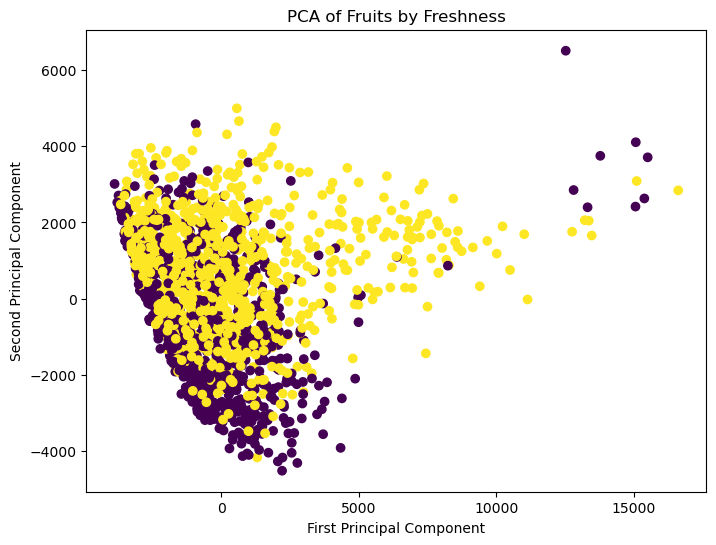

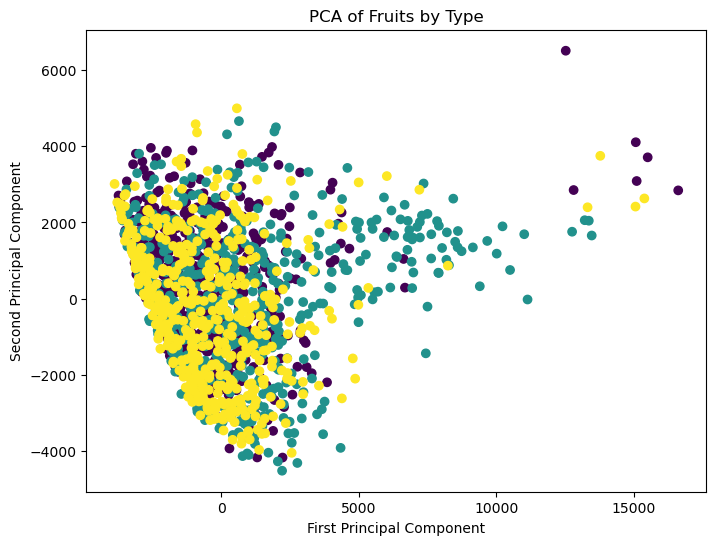

In [15]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
 
# Perform PCA
pca = PCA(n_components=2)
data_set_pca = pca.fit_transform(data_set)

# Plot the PCA
plt.figure(figsize=(8, 6))  
plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[0] == 'fresh' else 1 for x in dataset_target])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.title('PCA of Fruits by Freshness')

plt.show()

# PCA of fruits by type
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[1] == 'peach' else 1 if x[1] == 'pomegranate' else 2 for x in dataset_target])

plt.title('PCA of Fruits by Type')

plt.show()

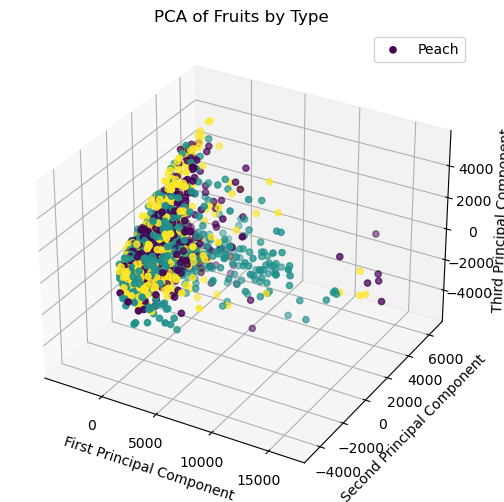

In [16]:
# PCA with 3 components
pca = PCA(n_components=3)
pca.fit(data_set)
data_set_pca = pca.transform(data_set)

# Plot the PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_set_pca[:, 0], 
           data_set_pca[:, 1], 
           data_set_pca[:, 2], 
           c=[0 if x[1] == 'peach' else 1 if x[1] == 'pomegranate' else 2 for x in dataset_target]
           )


ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Set the legend
ax.legend(['Peach', 'Pomegranate', 'Strawberry'])

plt.title('PCA of Fruits by Type')

plt.show()


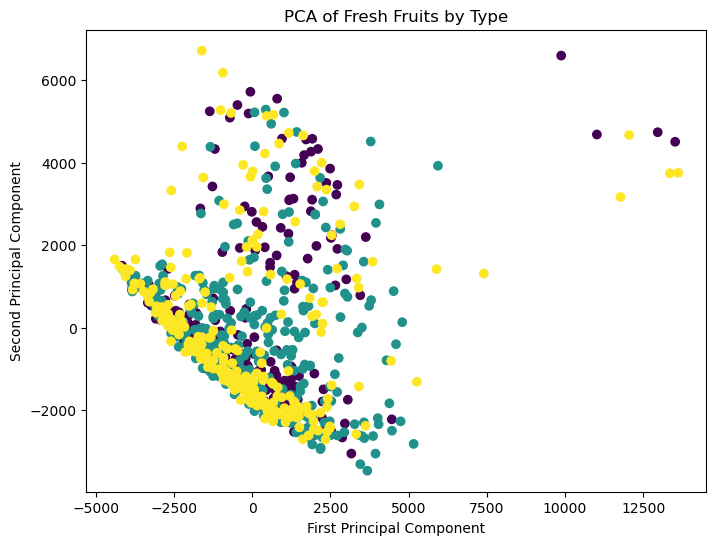

In [17]:
# PCA between fresh fruits only
fresh_fruits = [x for x in dataset_target if x[0] == 'fresh']
fresh_fruits_data = [data_set[i] for i, x in enumerate(dataset_target) if x[0] == 'fresh']

pca = PCA(n_components=2)
pca.fit(fresh_fruits_data)
fresh_fruits_data_pca = pca.transform(fresh_fruits_data)

# Plot the PCA
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(fresh_fruits_data_pca[:, 0], fresh_fruits_data_pca[:, 1], c=[0 if x[1] == 'peach' else 1 if x[1] == 'pomegranate' else 2 for x in fresh_fruits])

plt.title('PCA of Fresh Fruits by Type')

plt.show()


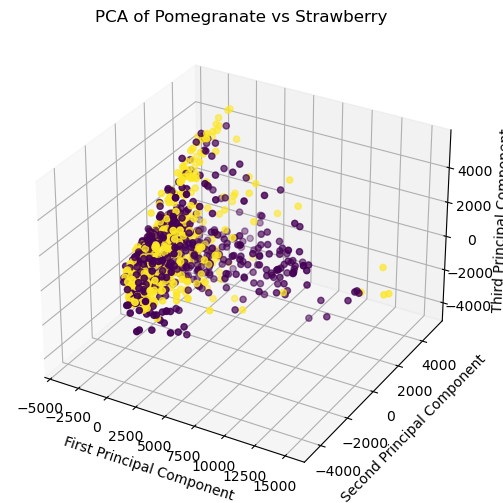

In [18]:
# PCA between pomegranate and strawberry only
pomegranate_strawberry = [x for x in dataset_target if x[1] in ['pomegranate', 'strawberry']]
pomegranate_strawberry_data = [data_set[i] for i, x in enumerate(dataset_target) if x[1] in ['pomegranate', 'strawberry']]
pca = PCA(n_components=3)
pca.fit(pomegranate_strawberry_data)
pomegranate_strawberry_data_pca = pca.transform(pomegranate_strawberry_data)

# Plot the PCA
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pomegranate_strawberry_data_pca[:, 0], pomegranate_strawberry_data_pca[:, 1], pomegranate_strawberry_data_pca[:, 2], c=[0 if x[1] == 'pomegranate' else 1 for x in pomegranate_strawberry])

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

plt.title('PCA of Pomegranate vs Strawberry')

plt.show()

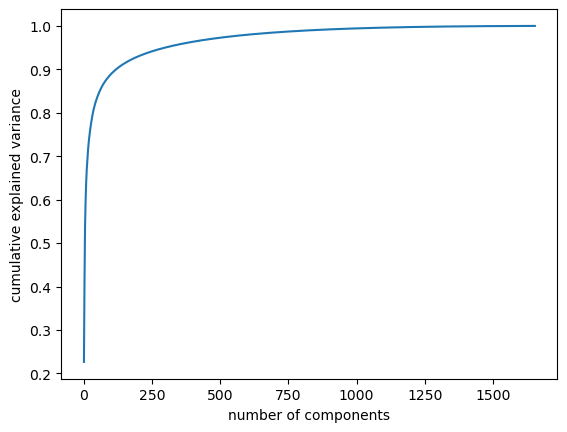

Number of components to explain 80% of the variance: 34


In [19]:
# Determine the number of components to use
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
pca = PCA().fit(data_set)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 80% of the variance
pca = PCA(0.80)
pca.fit(data_set)
print(f'Number of components to explain 80% of the variance: {pca.n_components_}')

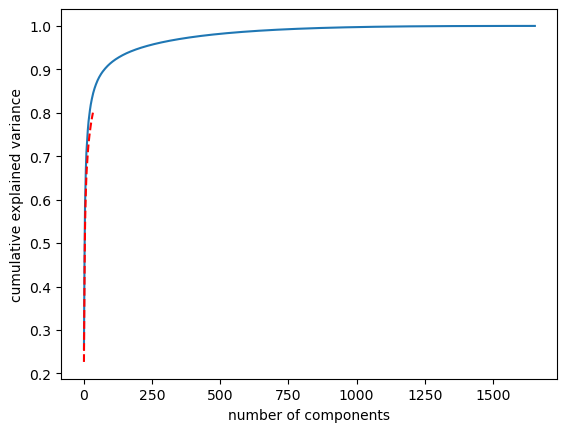

Number of components to explain 80% of the variance: 22


In [10]:
# Covert images to grayscale
data_set_gray = [cv2.cvtColor(x.reshape((h, w, 3)), cv2.COLOR_RGB2GRAY).flatten() for x in data_set]

# Compare the number of components to use
pca_grayscale = PCA().fit(data_set_gray)
plt.plot(np.cumsum(pca_grayscale.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 80% of the variance
pca_grayscale = PCA(0.80)
pca_grayscale.fit(data_set_gray)
print(f'Number of components to explain 80% of the variance: {pca_grayscale.n_components_}')



## Feature Extraction using DAISY

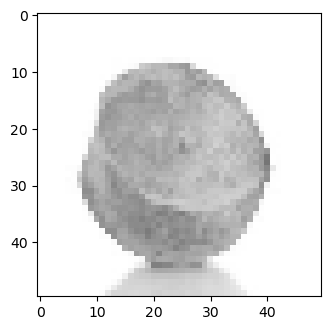

In [143]:
from skimage.io import imshow

#Selecting an image to visualize the DAISY descriptor 
plt.subplot(1,2,1)
idx_to_reconstruct = int(np.random.rand(1)*len(data_set))
img  = data_set_gray[idx_to_reconstruct].reshape(50,50)
imshow(img)
plt.grid(False)

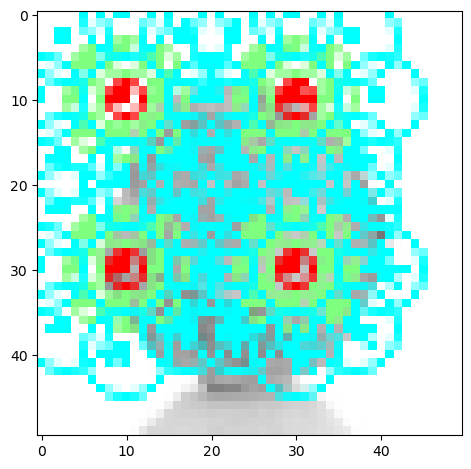

In [151]:
#Visualizing what the descriptor looks like
from skimage.feature import daisy

#lets first visualize what the DAISY descriptor looks like
features, img_desc = daisy(img, 
                            step=20, 
                           radius=10, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)
plt.show()

In [158]:
features = daisy(img, step=10, radius=20, rings=2, histograms=8, orientations=4, visualize=False)

def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=10, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

In [163]:
daisy_features = np.apply_along_axis(apply_daisy, 1, data_set_gray, (h,w))

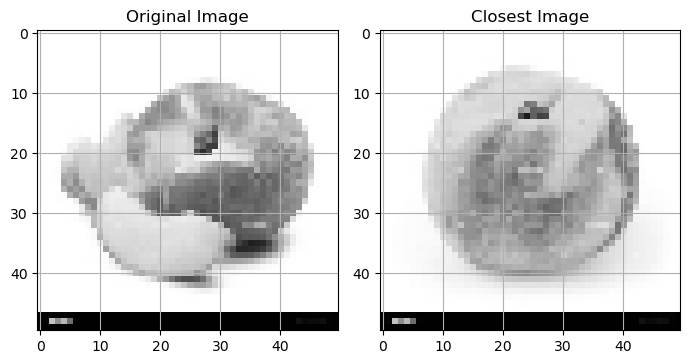

In [195]:
from sklearn.metrics.pairwise import pairwise_distances
import copy

dist_matrix = pairwise_distances(daisy_features)
idx1 = 1
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty 
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(data_set_gray[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(data_set_gray[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

Its not looking like the DAISY features will be useful to us, but we will make a KNN classifier to make sure.

In [196]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

#Creating dataset with PCA feature vector applied
pca_obj = PCA(n_components=22)
dataset_pca_features = pca_obj.fit_transform(data_set_gray)

# init a classifier for each feature space
knn_pca = KNeighborsClassifier(n_neighbors=1)
knn_dsy = KNeighborsClassifier(n_neighbors=1)
classifier_pca = MultiOutputClassifier(knn_pca, n_jobs=-1)
classifier_dsy = MultiOutputClassifier(knn_dsy, n_jobs=-1)

# separate the data into train/test
pca_train, pca_test, dsy_train, dsy_test, y_train, y_test = train_test_split(
    dataset_pca_features,daisy_features, dataset_target, test_size=0.2, train_size=0.8)

# fit each classifier and calculate predicted values
classifier_pca.fit(pca_train,y_train)
pred_pca = classifier_pca.predict(pca_test)

classifier_dsy.fit(dsy_train,y_train)
pred_dsy = classifier_dsy.predict(dsy_test)

#Printing results
print("PCA classifier score:", classifier_pca.score(pca_test, np.array(y_test)))
print("DAISY classifier score:", classifier_dsy.score(dsy_test, np.array(y_test)))

PCA classifier score: 0.3987915407854985
DAISY classifier score: 0.4350453172205438


The DAISY classifier produces a slightly higher accuracy rate, but both of our classifiers are still quite inaccurate.

## Key Point Matching 

# Sources
- https://www.kaggle.com/datasets/alihasnainch/fruits-dataset-for-classification
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html